In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 15.4 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dados Treino

## Análise Inicial

In [18]:
dados_treino= pd.read_csv('/content/drive/MyDrive/predict-future-sales/sales_train.csv')

In [19]:
dados_treino.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [20]:
dados_treino.shape

(2935849, 6)

In [21]:
#verificando os tipos dos Dados
dados_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [22]:
dados_treino.describe().round(2)

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24
std,9.42,16.23,6324.30,1729.80,2.62
min,0.00,0.00,0.00,-1.00,-22.00
25%,7.00,22.00,4476.00,249.00,1.00
50%,14.00,31.00,9343.00,399.00,1.00
75%,23.00,47.00,15684.00,999.00,1.00
max,33.00,59.00,22169.00,307980.00,2169.00


In [23]:
# Feature item_cnt_day para o tipo int
dados_treino['item_cnt_day'] = dados_treino['item_cnt_day'].astype(int)

In [24]:
dados_treino['valor_total'] = dados_treino['item_price'] * dados_treino['item_cnt_day']

In [25]:
# Mudando o tipo da feature date de object para datetime
dados_treino['date'] = pd.to_datetime(dados_treino['date'], format='%d.%m.%Y')

# Adicionando as features mes e ano
dados_treino['mes'] = dados_treino['date'].dt.month
dados_treino['ano'] = dados_treino['date'].dt.year

In [26]:
# reordenando as features
nova_ordem = ['date','date_block_num','mes','ano','shop_id','item_id','item_price','item_cnt_day','valor_total']
dados_treino = dados_treino[nova_ordem]

In [27]:
dados_treino.head(10)

,date,date_block_num,mes,ano,shop_id,item_id,item_price,item_cnt_day,valor_total
0,2013-01-02,0,1,2013,59,22154,999.00,1,999.00
1,2013-01-03,0,1,2013,25,2552,899.00,1,899.00
2,2013-01-05,0,1,2013,25,2552,899.00,-1,-899.00
3,2013-01-06,0,1,2013,25,2554,1709.05,1,1709.05
4,2013-01-15,0,1,2013,25,2555,1099.00,1,1099.00
5,2013-01-10,0,1,2013,25,2564,349.00,1,349.00
6,2013-01-02,0,1,2013,25,2565,549.00,1,549.00
7,2013-01-04,0,1,2013,25,2572,239.00,1,239.00
8,2013-01-11,0,1,2013,25,2572,299.00,1,299.00
9,2013-01-03,0,1,2013,25,2573,299.00,3,897.00


In [28]:
dados_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   mes             int32         
 3   ano             int32         
 4   shop_id         int64         
 5   item_id         int64         
 6   item_price      float64       
 7   item_cnt_day    int64         
 8   valor_total     float64       
dtypes: datetime64[ns](1), float64(2), int32(2), int64(4)
memory usage: 179.2 MB


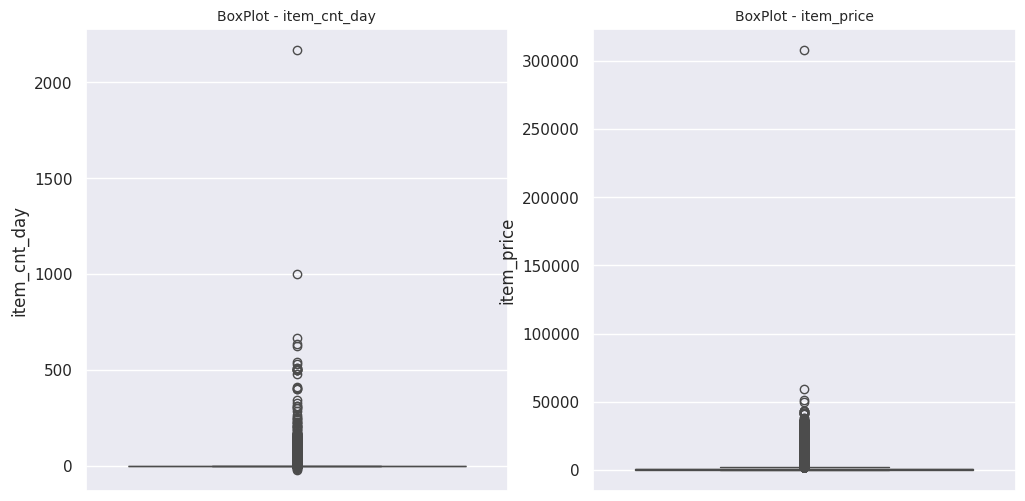

In [29]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.boxplot(y=dados_treino.item_cnt_day);
plt.title("BoxPlot - item_cnt_day", fontsize=10)

plt.subplot(1,2,2)
sns.boxplot(y=dados_treino.item_price);
plt.title("BoxPlot - item_price", fontsize=10);

* É possivel perceber que a feature item_cnt_day possui uma quantidade significativa de outliers.

* item_price tambem possui um aquantidade grande de outliers, pórem não faz sentido mexer, uma vez que é o preço de um item.

In [30]:
dados_treino.date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [31]:
# Número de vendas com valor negativo
np.sort(dados_treino.item_cnt_day.unique())

array([ -22,  -16,   -9,   -6,   -5,   -4,   -3,   -2,   -1,    1,    2,
          3,    4,    5,    6,    7,    8,    9,   10,   11,   12,   13,
         14,   15,   16,   17,   18,   19,   20,   21,   22,   23,   24,
         25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
         36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,
         47,   48,   49,   50,   51,   52,   53,   54,   55,   56,   57,
         58,   59,   60,   61,   62,   63,   64,   65,   66,   67,   68,
         69,   70,   71,   72,   73,   74,   75,   76,   77,   78,   79,
         80,   81,   82,   83,   84,   85,   86,   87,   88,   89,   90,
         91,   92,   93,   95,   96,   97,   98,   99,  100,  101,  102,
        103,  104,  105,  106,  107,  108,  109,  110,  111,  112,  113,
        114,  115,  116,  117,  118,  121,  124,  126,  127,  128,  129,
        130,  131,  132,  133,  134,  135,  138,  139,  140,  142,  145,
        146,  147,  148,  149,  150,  151,  153,  1

In [32]:
np.sort(dados_treino.shop_id.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [33]:
# Analisando valores duplicados
# Nota-se que não há valores duplicados. O método está retornando linhas com conteúdos diferentes.
dados_treino[dados_treino.duplicated()]

,date,date_block_num,mes,ano,shop_id,item_id,item_price,item_cnt_day,valor_total
76962,2013-01-05,0,1,2013,54,20130,149.0,1,149.0
1435367,2014-02-23,13,2,2014,50,3423,999.0,1,999.0
1496766,2014-03-23,14,3,2014,21,3423,999.0,1,999.0
1671873,2014-05-01,16,5,2014,50,3423,999.0,1,999.0
1866340,2014-07-12,18,7,2014,25,3423,999.0,1,999.0
2198566,2014-12-31,23,12,2014,42,21619,499.0,1,499.0


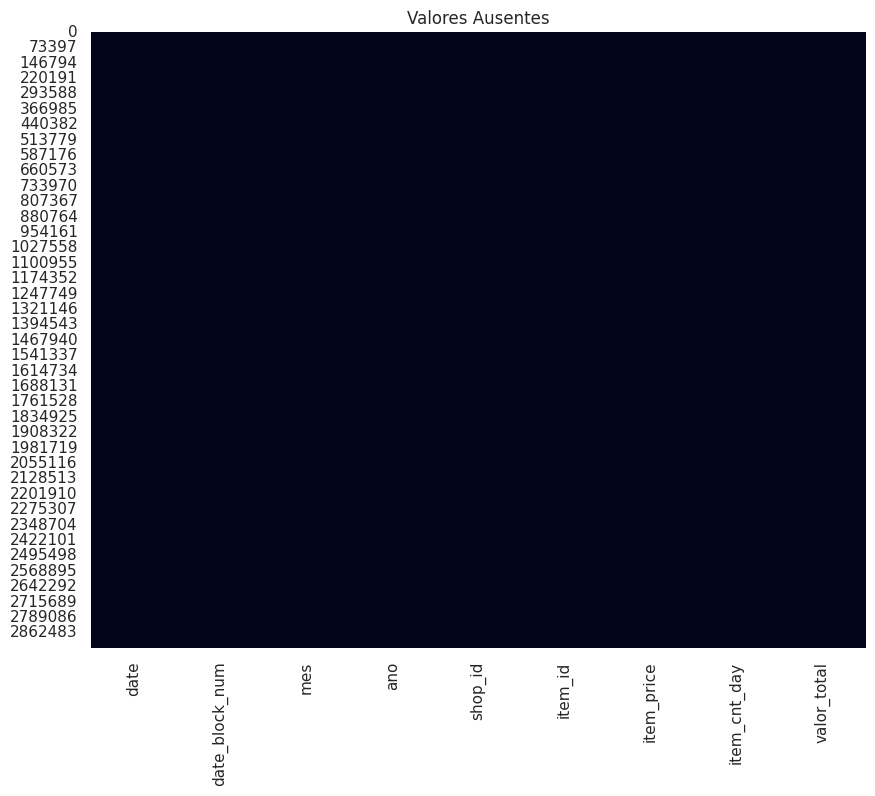

In [34]:
plt.figure(figsize=(10,8))
sns.heatmap(dados_treino.isna(),cbar=False)
plt.title('Valores Ausentes');

In [35]:
# nenhuma valor null
dados_treino.isnull().sum()

date              0
date_block_num    0
mes               0
ano               0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
valor_total       0
dtype: int64

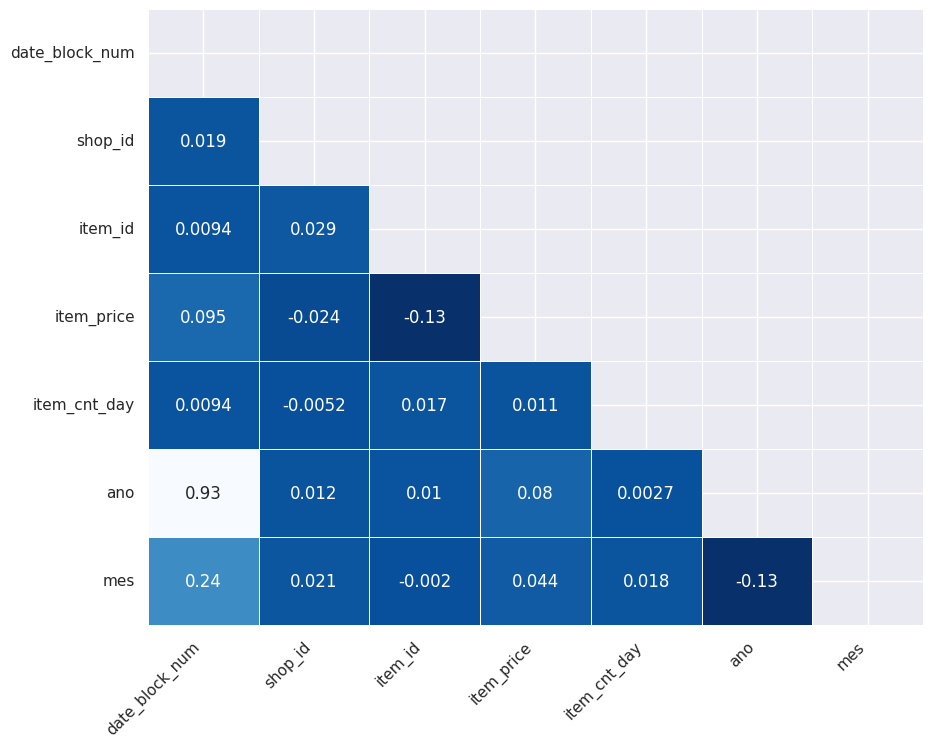

In [36]:
j = dados_treino.loc[:,['date_block_num',	'shop_id','item_id','item_price','item_cnt_day', 'ano','mes']]

plt.figure(figsize=(10,8))
sns.heatmap(j.corr(),  cbar=False, mask=np.triu(j.corr()), annot=True,linewidth=0.7, linecolor='white', cmap = 'Blues_r')
plt.xticks(ha="right", rotation=45)
plt.yticks(ha="right", rotation=0);


* Utilizei para ver se existia multicolinearidade. Além de analisar a variável target com as independentes.

* Não encontrei multicolinearidade.

* Não há Nenhuma feature com correlação alta com a variavel target

## Análise de Outlier

A melhor forma de detectar e eliminar outliers é calculando os limites máximo e mínimo, posteriormente eliminando os valores menores que o limite mínimo e maiores que o limite máximo. Porém, ao calcular os limites, seus valores foram pequenos demais, dando 1 tanto para o limite inferior e o 1º quartil, quanto para o 3º quartil e o limite superior. Assim, caso eliminasse os valores maiores que 1, não teria variabilidade nos dados de treino. Sendo que esses valores, maiores que 1, são plausíveis.

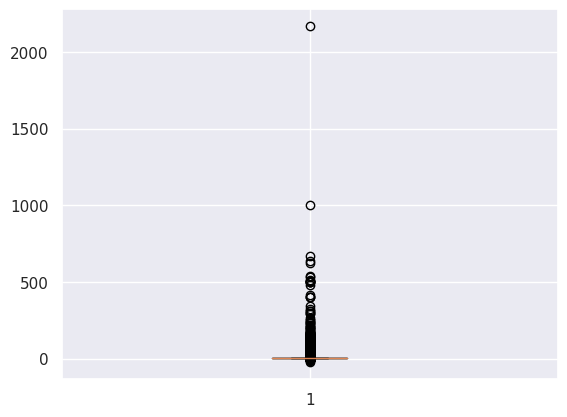

In [37]:
boxplot= plt.boxplot(x=dados_treino.item_cnt_day)

In [38]:
print(boxplot['whiskers'][0].get_ydata()) # limite inferior e 1 QUARTIL
print(boxplot['whiskers'][1].get_ydata()) # 3 QUARTIL e limite superior

[1. 1.]
[1. 1.]


In [39]:
print(len(dados_treino[dados_treino['item_cnt_day']>=100]))

151


In [40]:
# index_remove = dados_treino[(dados_treino['item_cnt_day']>=100) | (dados_treino['item_cnt_day']<1)].index
index_remove = dados_treino[(dados_treino['item_cnt_day']<1)].index
dados_treino.drop(index_remove, axis=0, inplace=True )

In [41]:
dados_treino.shape

(2928493, 9)

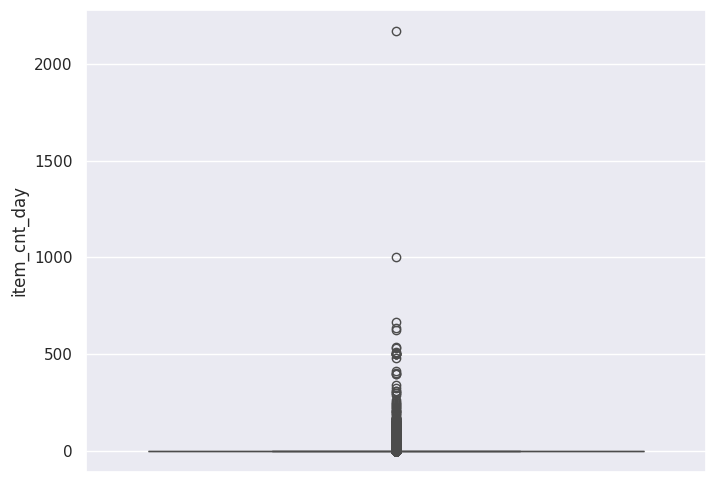

In [42]:
plt.figure(figsize=(8,6))

sns.boxplot(y=dados_treino.item_cnt_day);

## Analytics

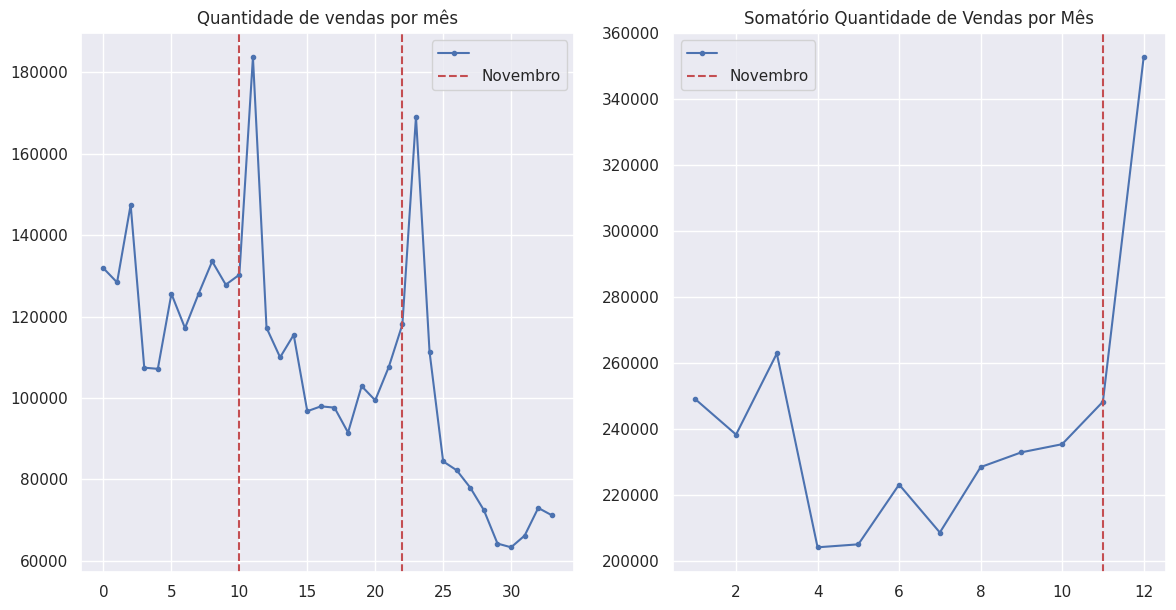

In [43]:
plt.figure(figsize=(14,7))


plt.subplot(1,2,1)
t_b_y = dados_treino[dados_treino['item_cnt_day']>0].groupby("date_block_num")['item_cnt_day'].sum()
plt.plot( t_b_y.index, t_b_y.values,marker = 'o', ms = 3, )
plt.axvline(x=10, color='r', linestyle='--')
plt.axvline(x=22, color='r', linestyle='--')
plt.legend(["","Novembro"]) ;
plt.title('Quantidade de vendas por mês');

plt.subplot(1,2,2)
t_b_y_2 = dados_treino[(dados_treino['item_cnt_day']>0) & (dados_treino['ano']<2015)].groupby("mes")['item_cnt_day'].sum()
plt.plot( t_b_y_2.index, t_b_y_2.values,marker = 'o', ms = 3, )
plt.axvline(x=11, color='r', linestyle='--')
plt.legend(["","Novembro"]) ;
plt.title('Somatório Quantidade de Vendas por Mês');



* É percepitivél que existem padrôes no gráfico 'Quantidade de vendas por mês'. Dezembro com um pico no número de vendas, janeiro em queda, março um leve aumento no número de vendas, no meses posteriores queda.

In [44]:
# Hisórico de vendas
# Mes de dezembro com as miores quantidades de vendas
dados_treino[dados_treino['item_cnt_day']>0].groupby("date_block_num")['item_cnt_day'].sum().sort_values(ascending=False)

date_block_num
11    183670
23    169055
2     147438
8     133551
0     131850
10    130270
1     128382
9     127815
7     125586
5     125583
22    118050
12    117243
6     117165
14    115501
24    111299
13    109975
21    107623
3     107439
4     107148
19    102910
20     99427
16     97938
17     97623
15     96744
18     91505
25     84419
26     82233
27     77948
32     72989
28     72435
33     71184
31     66196
29     64237
30     63316
Name: item_cnt_day, dtype: int64

In [45]:
dados_treino[ (dados_treino['ano']<2015)].groupby("mes")['item_cnt_day'].sum().sort_values(ascending=False)

mes
12    352725
3     262939
1     249093
11    248320
2     238357
10    235438
9     232978
8     228496
6     223206
7     208670
5     205086
4     204183
Name: item_cnt_day, dtype: int64

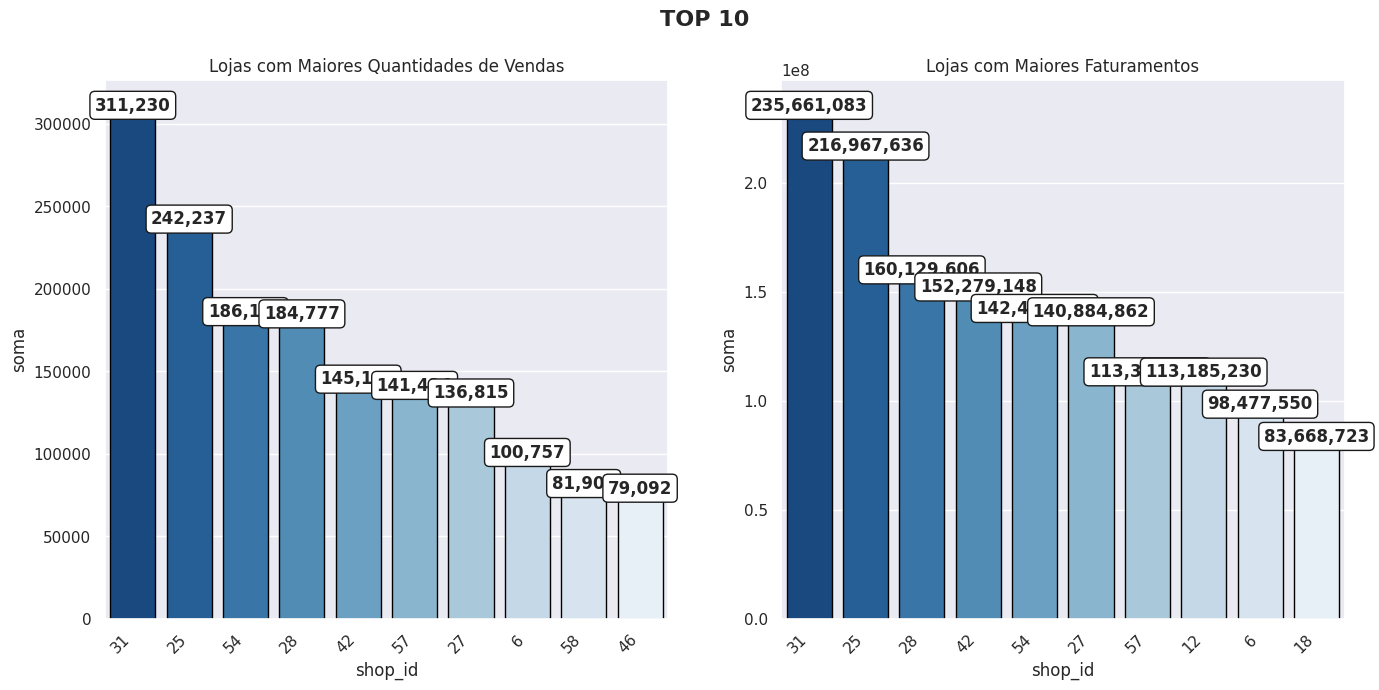

In [46]:
plt.figure(figsize=(16,7))

# Primeiro Gráfico
plt.subplot(1,2,1)
top_10_item_cnt_day = dados_treino[dados_treino['item_cnt_day']>0].groupby("shop_id")['item_cnt_day'].sum().sort_values(ascending=False).head(10)
x_x = pd.DataFrame(top_10_item_cnt_day.values, index=top_10_item_cnt_day.index.astype(str), columns = ["soma"])

ax=sns.barplot( x=x_x.index, y=x_x.soma, linewidth=1.0, edgecolor='black', palette='Blues_r')
plt.xticks(rotation=45, ha = "right")
plt.title("Lojas com Maiores Quantidades de Vendas");

for p in ax.patches:
    value = f"{p.get_height():,.0f}"
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 20
    ax.text(x, y, value, fontsize=12, ha='center', va='center', weight='bold',
           bbox=dict(facecolor='white', boxstyle='round', linewidth=1, edgecolor='k'))




# Segungo Gráfico
plt.subplot(1,2,2)
top_10_valor_total = dados_treino[dados_treino['item_cnt_day']>0].groupby("shop_id")['valor_total'].sum().sort_values(ascending=False).head(10)
x_x = pd.DataFrame(top_10_valor_total.values, index=top_10_valor_total.index.astype(str), columns = ["soma"])

ax=sns.barplot( x=x_x.index, y=x_x.soma, linewidth=1.0, edgecolor='black', palette='Blues_r')
plt.xticks(rotation=45, ha = "right")
plt.title("Lojas com Maiores Faturamentos");

for p in ax.patches:
    value = f"{p.get_height():,.0f}"
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 20
    ax.text(x, y, value, fontsize=12, ha='center', va='center', weight='bold',
           bbox=dict(facecolor='white', boxstyle='round', linewidth=1, edgecolor='k'))
plt.suptitle(t = "TOP 10", fontsize = 16, weight = 'bold');


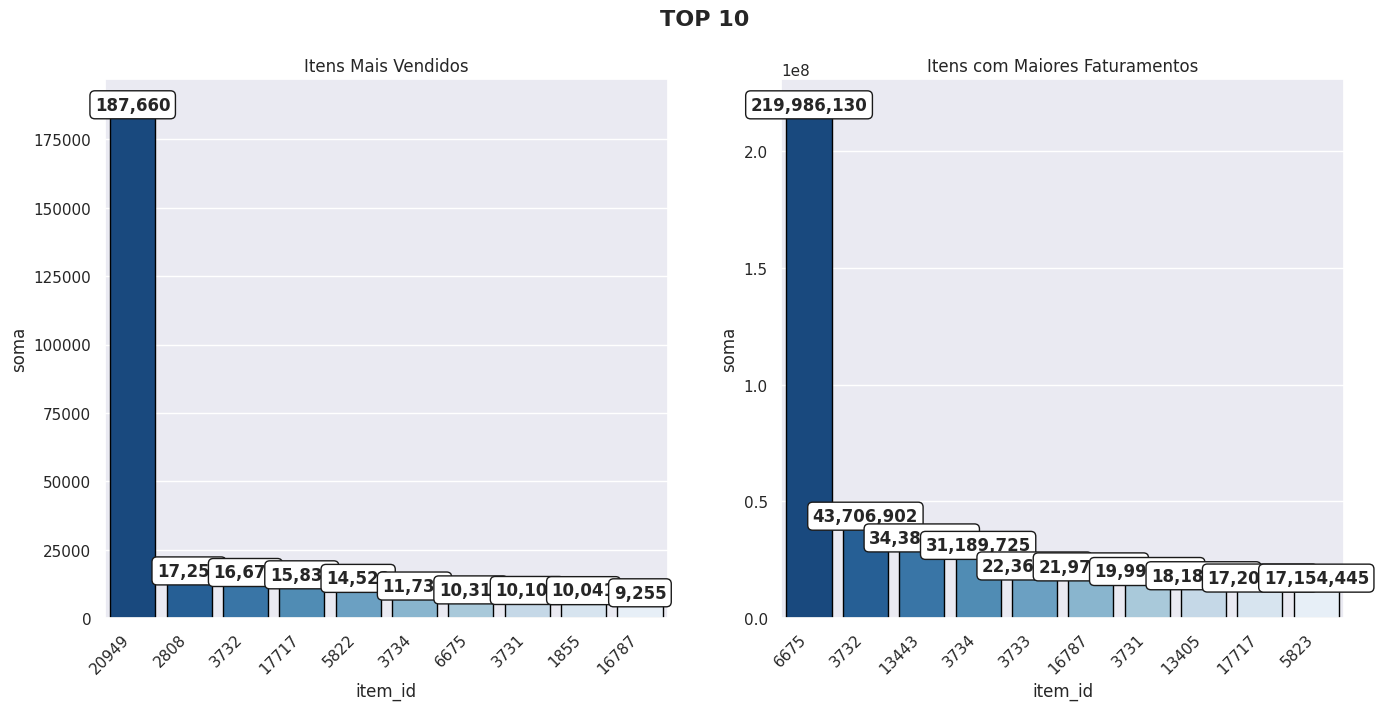

In [47]:
plt.figure(figsize=(16,7))

# Primeiro Gráfico
plt.subplot(1,2,1)
top_10_item_cnt_day = dados_treino[dados_treino['item_cnt_day']>0].groupby("item_id")['item_cnt_day'].sum().sort_values(ascending=False).head(10)
x_x = pd.DataFrame(top_10_item_cnt_day.values, index=top_10_item_cnt_day.index.astype(str), columns = ["soma"])

ax=sns.barplot( x=x_x.index, y=x_x.soma, linewidth=1.0, edgecolor='black', palette='Blues_r')
plt.xticks(rotation=45, ha = "right")
plt.title("Itens Mais Vendidos");

for p in ax.patches:
    value = f"{p.get_height():,.0f}"
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 20
    ax.text(x, y, value, fontsize=12, ha='center', va='center', weight='bold',
           bbox=dict(facecolor='white', boxstyle='round', linewidth=1, edgecolor='k'))




# Segungo Gráfico
plt.subplot(1,2,2)
top_10_valor_total = dados_treino[dados_treino['item_cnt_day']>0].groupby("item_id")['valor_total'].sum().sort_values(ascending=False).head(10)
x_x = pd.DataFrame(top_10_valor_total.values, index=top_10_valor_total.index.astype(str), columns = ["soma"])

ax=sns.barplot( x=x_x.index, y=x_x.soma, linewidth=1.0, edgecolor='black', palette='Blues_r')
plt.xticks(rotation=45, ha = "right")
plt.title("Itens com Maiores Faturamentos");

for p in ax.patches:
    value = f"{p.get_height():,.0f}"
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 20
    ax.text(x, y, value, fontsize=12, ha='center', va='center', weight='bold',
           bbox=dict(facecolor='white', boxstyle='round', linewidth=1, edgecolor='k'))
plt.suptitle(t = "TOP 10", fontsize = 16, weight = 'bold');

## Ajustando a escala dos Dados e Separando em Treino e Teste

### Padronização

In [48]:
#nova_ordem_pad = ['date_block_num','mes','ano','shop_id','item_id','item_cnt_day']
nova_ordem_pad = ['date_block_num','shop_id','item_id','item_cnt_day']
#nova_ordem_pad = ['shop_id','item_id','item_cnt_day']
var_pad = dados_treino[nova_ordem_pad ]

In [49]:
len(nova_ordem_pad)

4

In [50]:
#df_grouped_pad = var_pad.groupby(['date_block_num', 'mes', 'ano', 'shop_id', 'item_id'], as_index=False)['item_cnt_day'].sum()
df_grouped_pad = var_pad.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)['item_cnt_day'].sum()
#df_grouped_pad = var_pad.groupby(['shop_id', 'item_id'], as_index=False)['item_cnt_day'].sum()


In [51]:
df_grouped_pad

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6
1,0,0,33,3
2,0,0,35,1
3,0,0,43,1
4,0,0,51,2
...,...,...,...,...
1608221,33,59,22087,6
1608222,33,59,22088,2
1608223,33,59,22091,1
1608224,33,59,22100,1


In [97]:
round(df_grouped_pad.describe(),2)

,date_block_num,shop_id,item_id,item_cnt_day
count,1608226.00,1608226.00,1608226.00,1608226.00
mean,14.67,32.81,10681.48,2.27
std,9.54,16.54,6238.86,8.65
min,0.00,0.00,0.00,1.00
25%,6.00,21.00,5046.00,1.00
50%,14.00,31.00,10497.00,1.00
75%,23.00,47.00,16060.00,2.00
max,33.00,59.00,22169.00,2253.00


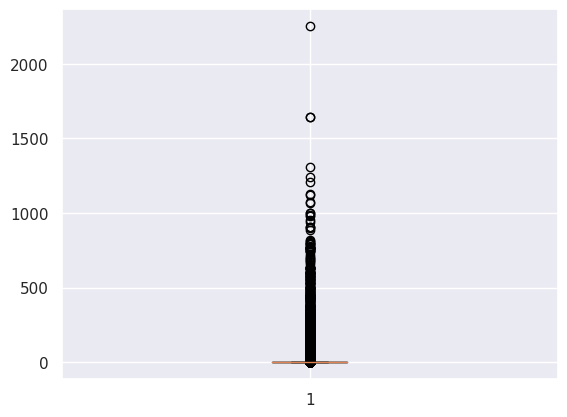

In [52]:
boxplot= plt.boxplot(x=df_grouped_pad.item_cnt_day)

In [53]:
print(boxplot['whiskers'][0].get_ydata()) # limite inferior e 1 QUARTIL
print(boxplot['whiskers'][1].get_ydata()) # 3 QUARTIL e limite superior

[1. 1.]
[2. 3.]


In [54]:
np.sort(df_grouped_pad.item_cnt_day.unique())

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
         23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
         34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
         45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
         67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
         78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,   95,   96,   97,   98,   99,
        100,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,
        111,  112,  113,  114,  115,  116,  117,  118,  119,  120,  121,
        122,  123,  124,  125,  126,  127,  128,  129,  130,  131,  132,
        133,  134,  135,  136,  137,  138,  139,  140,  141,  142,  143,
        144,  145,  146,  147,  148,  149,  150,  1

In [55]:
num_pad =len(nova_ordem_pad)-1
num_pad

3

In [56]:
x_pad = df_grouped_pad.iloc[:, 0:num_pad].values
y_pad = df_grouped_pad.iloc[:, num_pad].values

In [57]:
print(x_pad.shape)
print(y_pad.shape)

(1608226, 3)
(1608226,)


In [58]:
from sklearn.preprocessing import StandardScaler
x_pad_trans = StandardScaler().fit_transform(x_pad)

In [59]:
x_pad_trans

array([[-1.53683083, -1.98398026, -1.70696099],
       [-1.53683083, -1.98398026, -1.70680071],
       [-1.53683083, -1.98398026, -1.70648013],
       ...,
       [ 1.9214257 ,  1.58389624,  1.8287846 ],
       [ 1.9214257 ,  1.58389624,  1.83022717],
       [ 1.9214257 ,  1.58389624,  1.83054774]])

#### Separação dados de Teste e Treino - Padronização

In [60]:
from sklearn.model_selection import train_test_split

x_treino2, x_teste2, y_treino2, y_teste2 = train_test_split(x_pad_trans, y_pad, test_size=0.2, random_state=0)

x_treino2.shape, y_treino2.shape, x_teste2.shape, y_teste2.shape

((1286580, 3), (1286580,), (321646, 3), (321646,))

### Normalização

In [61]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [62]:
nova_ordem_norm = ['date_block_num','shop_id','item_id','item_cnt_day']
var_norm = dados_treino[nova_ordem_norm]

In [63]:
len(nova_ordem_norm)

4

In [64]:
df_grouped_norm = var_norm.groupby(['date_block_num',  'shop_id', 'item_id'], as_index=False)['item_cnt_day'].sum()

In [65]:
df_grouped_norm

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6
1,0,0,33,3
2,0,0,35,1
3,0,0,43,1
4,0,0,51,2
...,...,...,...,...
1608221,33,59,22087,6
1608222,33,59,22088,2
1608223,33,59,22091,1
1608224,33,59,22100,1


In [66]:
num_norm =len(nova_ordem_norm)-1
num_norm

3

In [67]:
x_norm = df_grouped_norm.iloc[:, 0:num_norm].values
y_norm = df_grouped_norm.iloc[:, num_norm].values

In [68]:
print(x_norm.shape)
print(y_norm.shape)

(1608226, 3)
(1608226,)


In [69]:
x_norm_trans = MinMaxScaler().fit_transform(x_norm)

In [70]:
x_norm_trans

array([[0.        , 0.        , 0.00144346],
       [0.        , 0.        , 0.00148857],
       [0.        , 0.        , 0.00157878],
       ...,
       [1.        , 1.        , 0.99648157],
       [1.        , 1.        , 0.99688755],
       [1.        , 1.        , 0.99697776]])

#### Separação dados de Teste e Treino - Normalização

In [71]:
from sklearn.model_selection import train_test_split

x_treino_norm, x_teste_norm, y_treino_norm, y_teste_norm = train_test_split(x_norm_trans, y_norm, test_size=0.2, random_state=0)

x_treino_norm.shape, y_treino_norm.shape, x_teste_norm.shape, y_teste_norm.shape

((1286580, 3), (1286580,), (321646, 3), (321646,))

## Modelos

### XGboost

In [72]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [73]:
import xgboost as xgb

In [74]:
model_xgb = xgb.XGBRegressor(tree_method='gpu_hist')

In [75]:
resultado_XG_r2_prev1=[]
resultado_XG_MAE_prev1=[]
resultado_XG_MSE_prev1=[]
resultado_XG_MAPE_prev1=[]

In [76]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(model_xgb,x_pad_trans, y_pad, cv = particoes, scoring = 'r2', verbose=1)
  resultado_XG_r2_prev1.append(scores.mean())

In [77]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(model_xgb,x_pad_trans, y_pad, cv = particoes, scoring = 'neg_mean_absolute_error', verbose=1)
  resultado_XG_MAE_prev1.append(scores.mean())

In [78]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(model_xgb,x_pad_trans, y_pad, cv = particoes, scoring = 'neg_mean_squared_error', verbose=1)
  resultado_XG_MSE_prev1.append(scores.mean())

In [79]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(model_xgb,x_pad_trans, y_pad, cv = particoes, scoring = 'neg_mean_absolute_percentage_error', verbose=1)
  resultado_XG_MAPE_prev1.append(scores.mean())

In [80]:
resultado_XG_r2_prev1

[0.10352733262624794,
 0.1042469826959052,
 0.10364144201992324,
 0.11687146280685234,
 0.11680779339413458,
 0.11107575451362864,
 0.10454040539517324,
 0.11762467734684519,
 0.10386580466042586,
 0.10650081117199214,
 0.11152203056502148,
 0.10970963560780386,
 0.1092292953326071,
 0.1097378893685538,
 0.10496418507744547,
 0.11282141869024623,
 0.10943488091318301,
 0.10585615329474263,
 0.10590120051964577,
 0.10811767197304134]

* 5 features, padro:
[0.11609328924664748,
 0.11054980649214978,
 0.10796842055349465,
 0.11218656620185288,
 0.1120283624056669]


* 4 features, padro, sem o ano:
[0.11609328924664748,
 0.11054980649214978,
 0.10796842055349465,
 0.11218656620185288,
 0.1120283624056669]


* 3 features, padro, sem mes e ano:
[0.1179999772644635,
 0.1166611219911031,
 0.11543992440977173,
 0.11452445015933821,
 0.12116742050484983]

* 2 features, padro, sem mes, ano e date_block_num :
[-0.005267344325808132,
 -0.006895321766623619,
 0.0003447105521612981,
 -0.008650872440097945,
 -0.00836715815352893]

->

* 5 features, norm:
[0.11609328924664748,
 0.11054980649214978,
 0.10796842055349465,
 0.11218656620185288,
 0.1120283624056669]

* 4 features, norm, sem o ano:
[0.11609328924664748,
 0.11054980649214978,
 0.10796842055349465,
 0.11218656620185288,
 0.1120283624056669]

* 3 features, padro, sem mes e ano:
[0.1179999772644635,
 0.1166611219911031,
 0.11543992440977173,
 0.11452445015933821,
 0.12116742050484983]

 ->

* 5 features, sem nada:
[0.1179999772644635,
 0.1166611219911031,
 0.11543992440977173,
 0.11452445015933821,
 0.12116742050484983]

* 3 features, sem nada, sem mes e ano:
[0.1179999772644635,
 0.1166611219911031,
 0.11543992440977173,
 0.11452445015933821,
 0.12116742050484983]




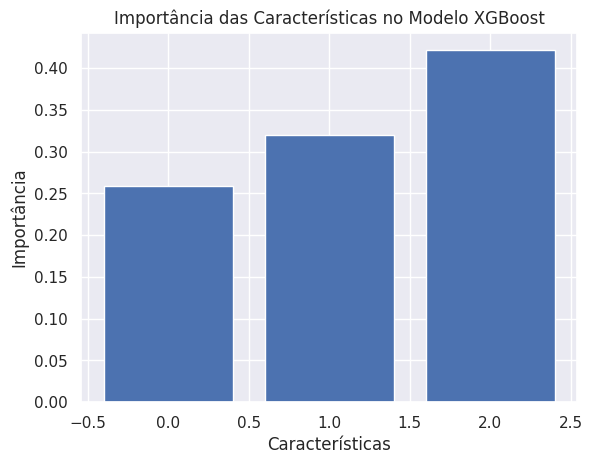

In [81]:
model_xgb.fit(x_teste2, y_teste2)
importance = model_xgb.feature_importances_

# Plotando a importância das características
plt.bar(range(len(importance)), importance)
plt.xlabel('Características')
plt.ylabel('Importância')
plt.title('Importância das Características no Modelo XGBoost')
plt.show()

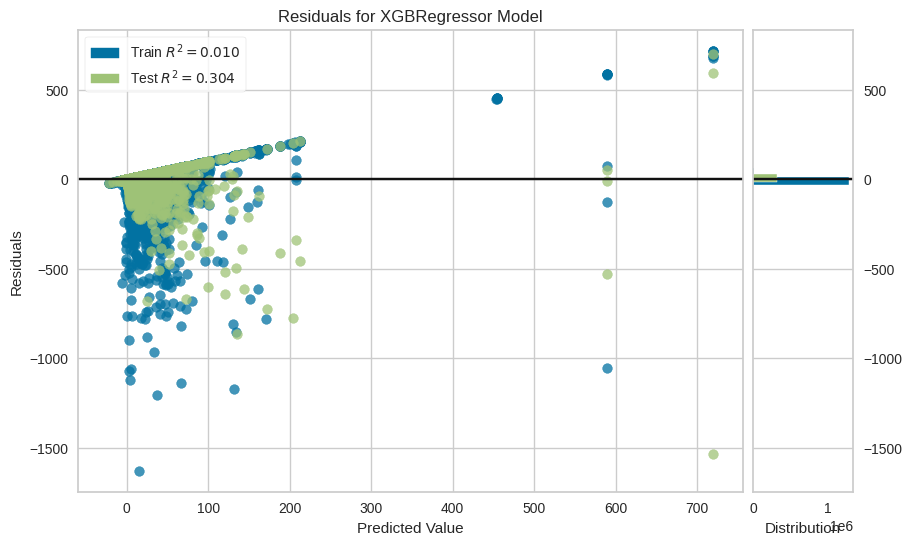

In [82]:
from yellowbrick.regressor import ResidualsPlot
fig, ax = plt.subplots(figsize=(10, 6))
rpv = ResidualsPlot(model_xgb)
rpv.fit(x_treino2, y_treino2)
rpv.score(x_teste2, y_teste2)
rpv.poof();

In [83]:
MAE_prev1_xg = np.mean(resultado_XG_MAE_prev1)
MSE_prev1_xg = np.mean(resultado_XG_MSE_prev1)
MAPE_prev1_xg = np.mean(resultado_XG_MAPE_prev1)
r_2_prev1_xg = np.mean(resultado_XG_r2_prev1)

In [84]:

t = np.array([MAE_prev1_xg ,MSE_prev1_xg,MAPE_prev1_xg,r_2_prev1_xg])
t.shape = (1,4)

dtf_prev1_xg = pd.DataFrame(t, index=['Valores'], columns=['MAE','RMSE', 'MAPE','R^2'])
round(dtf_prev1_xg ,3)

,MAE,RMSE,MAPE,R^2
Valores,-1.615,-66.743,-0.829,0.109


### CatBoost

In [85]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor

In [86]:
model_cat = CatBoostRegressor(task_type='GPU')

In [87]:
resultado_CAT_r2_prev1=[]
resultado_CAT_MAE_prev1=[]
resultado_CAT_MSE_prev1=[]
resultado_CAT_MAPE_prev1=[]

In [88]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(model_cat, x_pad_trans, y_pad, cv = particoes, scoring = 'r2')
  resultado_CAT_r2_prev1.append(scores.mean())

A saída de streaming foi truncada nas últimas 5000 linhas.
4:	learn: 8.5039824	total: 24.9ms	remaining: 4.95s
5:	learn: 8.4952917	total: 29.7ms	remaining: 4.92s
6:	learn: 8.4877735	total: 34.7ms	remaining: 4.92s
7:	learn: 8.4819613	total: 39.7ms	remaining: 4.92s
8:	learn: 8.4771799	total: 44.5ms	remaining: 4.9s
9:	learn: 8.4732578	total: 49.4ms	remaining: 4.89s
10:	learn: 8.4696877	total: 54.4ms	remaining: 4.89s
11:	learn: 8.4672503	total: 59.3ms	remaining: 4.88s
12:	learn: 8.4647456	total: 64.3ms	remaining: 4.88s
13:	learn: 8.4632648	total: 69ms	remaining: 4.86s
14:	learn: 8.4612250	total: 74ms	remaining: 4.86s
15:	learn: 8.4595676	total: 78.8ms	remaining: 4.85s
16:	learn: 8.4581197	total: 83.6ms	remaining: 4.84s
17:	learn: 8.4571580	total: 88.4ms	remaining: 4.82s
18:	learn: 8.4558498	total: 93.3ms	remaining: 4.82s
19:	learn: 8.4528935	total: 98.2ms	remaining: 4.81s
20:	learn: 8.4505752	total: 103ms	remaining: 4.78s
21:	learn: 8.4496409	total: 107ms	remaining: 4.76s
22:	learn: 8.44539

In [89]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(model_cat, x_pad_trans, y_pad, cv = particoes, scoring = 'neg_mean_absolute_error')
  resultado_CAT_MAE_prev1.append(scores.mean())

A saída de streaming foi truncada nas últimas 5000 linhas.
4:	learn: 8.5039824	total: 23ms	remaining: 4.58s
5:	learn: 8.4952917	total: 27.5ms	remaining: 4.56s
6:	learn: 8.4877735	total: 31.9ms	remaining: 4.52s
7:	learn: 8.4819613	total: 36.3ms	remaining: 4.5s
8:	learn: 8.4771799	total: 40.6ms	remaining: 4.47s
9:	learn: 8.4732578	total: 45ms	remaining: 4.46s
10:	learn: 8.4696877	total: 49.3ms	remaining: 4.44s
11:	learn: 8.4672503	total: 53.8ms	remaining: 4.43s
12:	learn: 8.4647456	total: 58.3ms	remaining: 4.42s
13:	learn: 8.4632648	total: 62.4ms	remaining: 4.39s
14:	learn: 8.4612250	total: 66.8ms	remaining: 4.39s
15:	learn: 8.4595676	total: 71ms	remaining: 4.37s
16:	learn: 8.4581197	total: 75.4ms	remaining: 4.36s
17:	learn: 8.4571580	total: 79.6ms	remaining: 4.34s
18:	learn: 8.4558498	total: 84ms	remaining: 4.34s
19:	learn: 8.4528935	total: 88.3ms	remaining: 4.33s
20:	learn: 8.4505752	total: 92.6ms	remaining: 4.32s
21:	learn: 8.4496409	total: 96.8ms	remaining: 4.3s
22:	learn: 8.4453984	

In [90]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(model_cat, x_pad_trans, y_pad, cv = particoes, scoring = 'neg_mean_squared_error')
  resultado_CAT_MSE_prev1.append(scores.mean())

A saída de streaming foi truncada nas últimas 5000 linhas.
4:	learn: 8.5039824	total: 23.6ms	remaining: 4.7s
5:	learn: 8.4952917	total: 28.2ms	remaining: 4.67s
6:	learn: 8.4877735	total: 32.7ms	remaining: 4.64s
7:	learn: 8.4819613	total: 37.3ms	remaining: 4.62s
8:	learn: 8.4771799	total: 41.8ms	remaining: 4.6s
9:	learn: 8.4732578	total: 46.3ms	remaining: 4.58s
10:	learn: 8.4696877	total: 51ms	remaining: 4.58s
11:	learn: 8.4672503	total: 55.5ms	remaining: 4.57s
12:	learn: 8.4647456	total: 60.2ms	remaining: 4.57s
13:	learn: 8.4632648	total: 64.6ms	remaining: 4.55s
14:	learn: 8.4612250	total: 69.2ms	remaining: 4.55s
15:	learn: 8.4595676	total: 73.6ms	remaining: 4.53s
16:	learn: 8.4581197	total: 78.1ms	remaining: 4.52s
17:	learn: 8.4571580	total: 82.5ms	remaining: 4.5s
18:	learn: 8.4558498	total: 87ms	remaining: 4.49s
19:	learn: 8.4528935	total: 91.4ms	remaining: 4.48s
20:	learn: 8.4505752	total: 95.9ms	remaining: 4.47s
21:	learn: 8.4496409	total: 100ms	remaining: 4.45s
22:	learn: 8.445398

In [91]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(model_cat, x_pad_trans, y_pad, cv = particoes, scoring = 'neg_mean_absolute_percentage_error')
  resultado_CAT_MAPE_prev1.append(scores.mean())

A saída de streaming foi truncada nas últimas 5000 linhas.
4:	learn: 8.5039824	total: 23.1ms	remaining: 4.6s
5:	learn: 8.4952917	total: 27.6ms	remaining: 4.57s
6:	learn: 8.4877735	total: 32ms	remaining: 4.54s
7:	learn: 8.4819613	total: 36.4ms	remaining: 4.51s
8:	learn: 8.4771799	total: 40.8ms	remaining: 4.49s
9:	learn: 8.4732578	total: 45.3ms	remaining: 4.49s
10:	learn: 8.4696877	total: 49.8ms	remaining: 4.48s
11:	learn: 8.4672503	total: 54.2ms	remaining: 4.46s
12:	learn: 8.4647456	total: 58.8ms	remaining: 4.46s
13:	learn: 8.4632648	total: 62.9ms	remaining: 4.43s
14:	learn: 8.4612250	total: 67.4ms	remaining: 4.43s
15:	learn: 8.4595676	total: 71.7ms	remaining: 4.41s
16:	learn: 8.4581197	total: 76.1ms	remaining: 4.4s
17:	learn: 8.4571580	total: 80.4ms	remaining: 4.39s
18:	learn: 8.4558498	total: 85ms	remaining: 4.39s
19:	learn: 8.4528935	total: 89.4ms	remaining: 4.38s
20:	learn: 8.4505752	total: 93.7ms	remaining: 4.37s
21:	learn: 8.4496409	total: 97.9ms	remaining: 4.35s
22:	learn: 8.4453

In [92]:
resultado_CAT_r2_prev1

[0.05511616397836845,
 0.06358400948737465,
 0.05295625630021369,
 0.06266797847302076,
 0.052918563156597785,
 0.05785590936824751,
 0.055600173618851535,
 0.0631098314662618,
 0.060533277290167074,
 0.05748944165223856,
 0.06003870714576494,
 0.056481515501601,
 0.05743649861217063,
 0.05790373459390048,
 0.06925816814196065,
 0.05276475583736283,
 0.06167850831940498,
 0.06212046418027893,
 0.0637211952430187,
 0.05636297189023263]

Learning rate set to 0.086056
0:	learn: 9.1890005	total: 3.13ms	remaining: 3.13s
1:	learn: 9.1728105	total: 5.28ms	remaining: 2.63s
2:	learn: 9.1572136	total: 7.69ms	remaining: 2.56s
3:	learn: 9.1416050	total: 10.1ms	remaining: 2.51s
4:	learn: 9.1308017	total: 12.5ms	remaining: 2.48s
5:	learn: 9.1180237	total: 14.8ms	remaining: 2.45s
6:	learn: 9.1105776	total: 17.1ms	remaining: 2.43s
7:	learn: 9.1037254	total: 19.5ms	remaining: 2.41s
8:	learn: 9.0976301	total: 21.8ms	remaining: 2.4s
9:	learn: 9.0924667	total: 24.1ms	remaining: 2.38s
10:	learn: 9.0890881	total: 26.4ms	remaining: 2.38s
11:	learn: 9.0839678	total: 28.8ms	remaining: 2.37s
12:	learn: 9.0806302	total: 31.2ms	remaining: 2.37s
13:	learn: 9.0776264	total: 33.6ms	remaining: 2.36s
14:	learn: 9.0741528	total: 35.9ms	remaining: 2.36s
15:	learn: 9.0457963	total: 38.3ms	remaining: 2.35s
16:	learn: 9.0437971	total: 40.6ms	remaining: 2.35s
17:	learn: 9.0408897	total: 43ms	remaining: 2.34s
18:	learn: 9.0369015	total: 45.3ms	remaining: 2

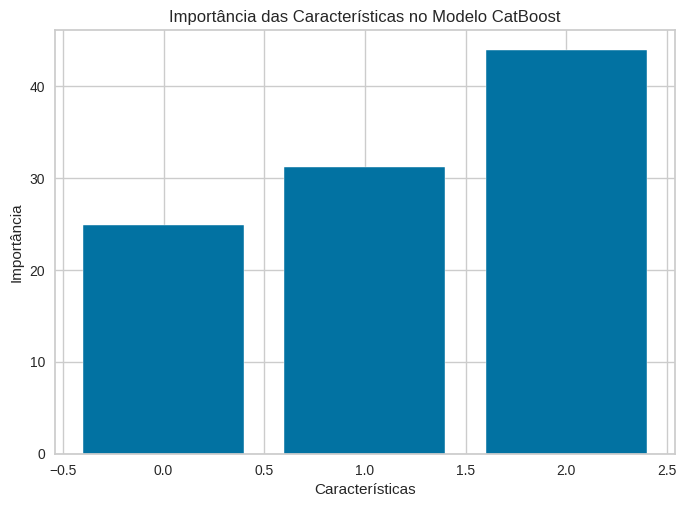

In [93]:
model_cat.fit(x_teste2, y_teste2)
importance = model_cat.feature_importances_

# Plotando a importância das características
plt.bar(range(len(importance)), importance)
plt.xlabel('Características')
plt.ylabel('Importância')
plt.title('Importância das Características no Modelo CatBoost')
plt.show();

In [98]:
"""from yellowbrick.regressor import ResidualsPlot
fig, ax = plt.subplots(figsize=(10, 6))
rpv = ResidualsPlot(model_cat)
rpv.fit(x_treino2, y_treino2)
rpv.score(x_teste2, y_teste2)
rpv.poof();"""

'from yellowbrick.regressor import ResidualsPlot\nfig, ax = plt.subplots(figsize=(10, 6))\nrpv = ResidualsPlot(model_cat)\nrpv.fit(x_treino2, y_treino2)\nrpv.score(x_teste2, y_teste2)\nrpv.poof();'

In [99]:
r_2_prev1_cat = np.mean(resultado_CAT_r2_prev1)
MAE_prev1_cat = np.mean(resultado_CAT_MAE_prev1)
MSE_prev1_cat = np.mean(resultado_CAT_MSE_prev1)
MAPE_prev1_cat = np.mean(resultado_CAT_MAPE_prev1)

In [100]:
t = np.array([MAE_prev1_cat ,MSE_prev1_cat,MAPE_prev1_cat,r_2_prev1_cat])
t.shape = (1,4)

dtf_prev1_cat = pd.DataFrame(t, index=['Valores'], columns=['MAE','RMSE', 'MAPE','R^2'])
round(dtf_prev1_cat ,3)

,MAE,RMSE,MAPE,R^2
Valores,-1.693,-70.401,-0.88,0.059


### Lightgbm

In [101]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import lightgbm as lgb

In [102]:
model_lgb = lgb.LGBMRegressor(tree_method='gpu_hist')

In [103]:
resultado_LGB_r2_prev1=[]
resultado_LGB_MAE_prev1=[]
resultado_LGB_MSE_prev1=[]
resultado_LGB_MAPE_prev1=[]

In [104]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(model_lgb, x_pad_trans, y_pad, cv = particoes, scoring = 'r2')
  resultado_LGB_r2_prev1.append(scores.mean())

[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 1447403, number of used features: 3
[LightGBM] [Info] Start training from score 2.271738
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 1447403, number o

In [105]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(model_lgb, x_pad_trans, y_pad, cv = particoes, scoring = 'neg_mean_absolute_error')
  resultado_LGB_MAE_prev1.append(scores.mean())

[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 1447403, number of used features: 3
[LightGBM] [Info] Start training from score 2.271738
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 1447403, number o

In [106]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(model_lgb, x_pad_trans, y_pad, cv = particoes, scoring = 'neg_mean_squared_error')
  resultado_LGB_MSE_prev1.append(scores.mean())

[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 1447403, number of used features: 3
[LightGBM] [Info] Start training from score 2.271738
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 1447403, number o

In [107]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(model_lgb, x_pad_trans, y_pad, cv = particoes, scoring = 'neg_mean_absolute_percentage_error')
  resultado_LGB_MAPE_prev1.append(scores.mean())

[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 1447403, number of used features: 3
[LightGBM] [Info] Start training from score 2.271738
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 1447403, number o

In [108]:
resultado_LGB_r2_prev1

[0.10366297481627935,
 0.10388882965751196,
 0.10444620070486563,
 0.10924676953896681,
 0.10634322383118959,
 0.10700250416696785,
 0.10518573204353421,
 0.10985489041255034,
 0.10095078899289875,
 0.10819642904333823,
 0.10808977884609867,
 0.11005858780357296,
 0.1056072775147876,
 0.10202962593293145,
 0.10795768754300847,
 0.10068080243965469,
 0.1083750454748347,
 0.10975012776257916,
 0.10379291779816294,
 0.10207023710971619]

* 5 features, padro:
[0.10605173073360574,
 0.10256488714125407,
 0.10268432073647231,
 0.1082190141224866,
 0.10204593091685095]


 * 3 features,sem mes e ano. padro:
 [0.11216811401220587, 0.10661847057906967,0.1073406020283046, 0.11517385324384868,0.10911346298477109]

[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 321646, number of used features: 3
[LightGBM] [Info] Start training from score 2.278154


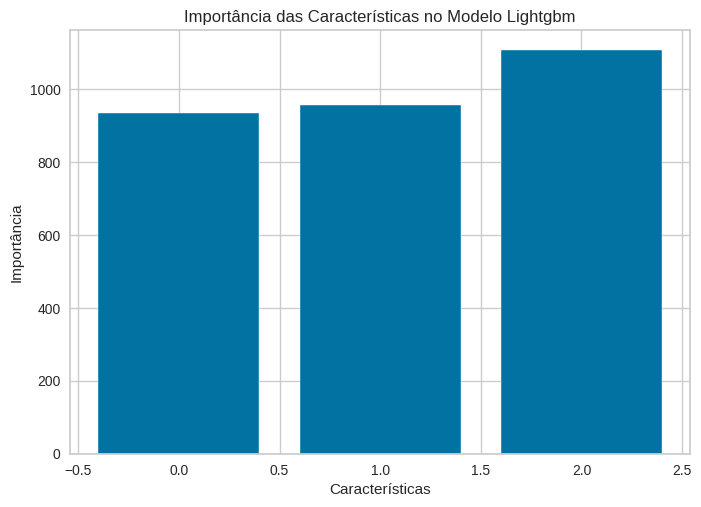

In [109]:
model_lgb.fit(x_teste2, y_teste2)
importance = model_lgb.feature_importances_

# Plotando a importância das características
plt.bar(range(len(importance)), importance)
plt.xlabel('Características')
plt.ylabel('Importância')
plt.title('Importância das Características no Modelo Lightgbm')
plt.show();

[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: tree_method


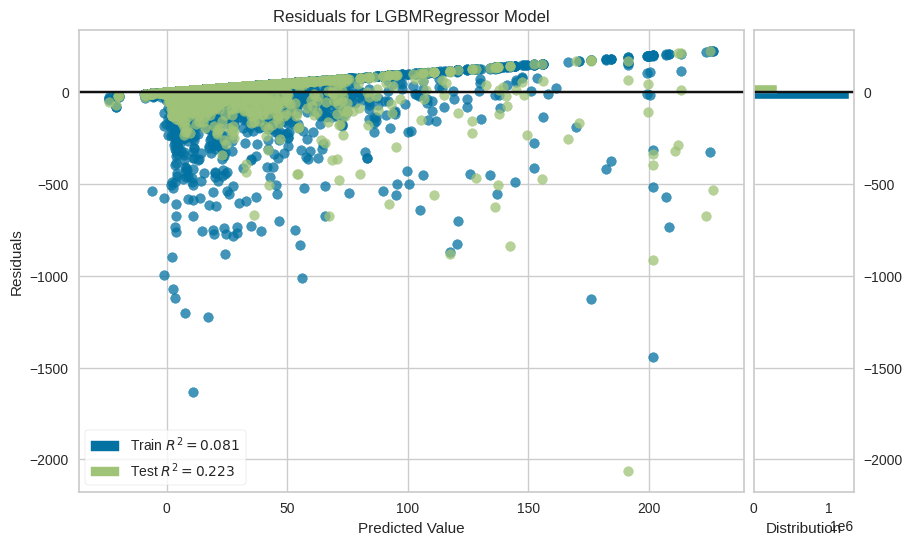

In [110]:
from yellowbrick.regressor import ResidualsPlot
fig, ax = plt.subplots(figsize=(10, 6))
rpv = ResidualsPlot(model_lgb)
rpv.fit(x_treino2, y_treino2)
rpv.score(x_teste2, y_teste2)
rpv.poof();

In [111]:
r_2_prev1_lgb = np.mean(resultado_LGB_r2_prev1)
MAE_prev1_lgb = np.mean(resultado_LGB_MAE_prev1)
MSE_prev1_lgb = np.mean(resultado_LGB_MSE_prev1)
MAPE_prev1_lgb = np.mean(resultado_LGB_MAPE_prev1)

In [112]:
t = np.array([MAE_prev1_lgb ,MSE_prev1_lgb, MAPE_prev1_lgb, r_2_prev1_lgb])
t.shape = (1,4)

dtf_prev1_lgb = pd.DataFrame(t, index=['Valores'], columns=['MAE','RMSE', 'MAPE','R^2'])
round(dtf_prev1_lgb ,3)

,MAE,RMSE,MAPE,R^2
Valores,-1.651,-66.973,-0.86,0.106


### Regressão Linear

In [113]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [120]:
lr_model = LinearRegression()
#lr.fit(x_treino2, y_treino2)

In [115]:
resultado_LR_r2_prev1=[]
resultado_LR_MAE_prev1=[]
resultado_LR_MSE_prev1=[]
resultado_LR_MAPE_prev1=[]

In [121]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(lr_model, x_pad_trans, y_pad, cv = particoes, scoring = 'r2', verbose=1)
  resultado_LR_r2_prev1.append(scores.mean())

In [122]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(lr_model, x_pad_trans, y_pad, cv = particoes, scoring = 'neg_mean_absolute_error', verbose=1)
  resultado_LR_MAE_prev1.append(scores.mean())

In [123]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(lr_model, x_pad_trans, y_pad, cv = particoes, scoring = 'neg_mean_squared_error', verbose=1)
  resultado_LR_MSE_prev1.append(scores.mean())

In [124]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(lr_model, x_pad_trans, y_pad, cv = particoes, scoring = 'neg_mean_absolute_percentage_error', verbose=1)
  resultado_LR_MAPE_prev1.append(scores.mean())

In [125]:
resultado_LR_r2_prev1

[0.0001323074295248805,
 0.00013134814161029905,
 0.00012547578894275268,
 0.0001308126999513104,
 0.00012821898490074092,
 0.0001299731842813956,
 0.0001311977026815625,
 0.00012157641853454138,
 0.00012526622422022183,
 0.00012935725300392554,
 0.0001292393327861907,
 0.00013417952151263403,
 0.00012732258597613065,
 0.00012964447238257294,
 0.0001222790272103369,
 0.00012055515504679759,
 0.0001309221374977354,
 0.00013285819196521276,
 0.00013114881485304375,
 0.00013370709771693968]

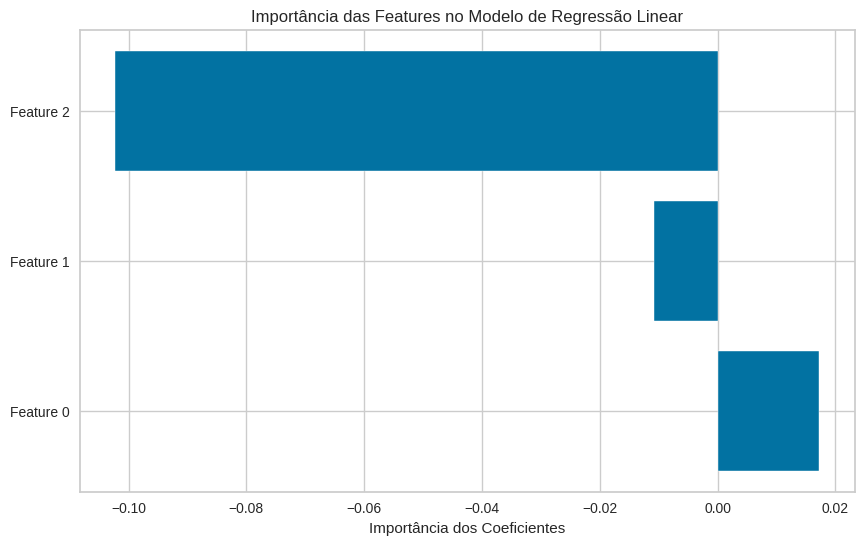

In [128]:
lr_model.fit(x_teste2, y_teste2)
importance = lr_model.coef_

# Plotando a importância das características
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(importance)), importance, align='center')
plt.yticks(np.arange(len(importance)), [f'Feature {i}' for i in range(len(importance))])
plt.xlabel('Importância dos Coeficientes')
plt.title('Importância das Features no Modelo de Regressão Linear')
plt.show()

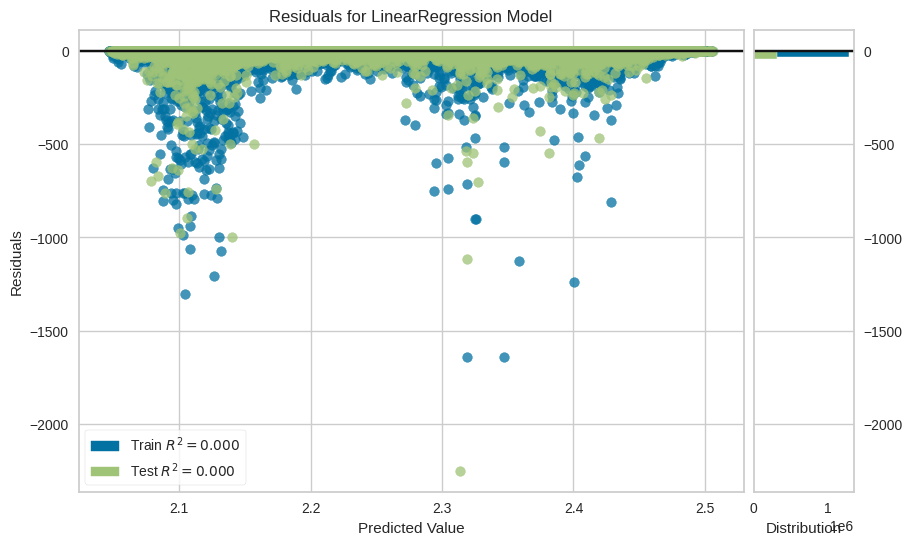

In [129]:
from yellowbrick.regressor import ResidualsPlot
fig, ax = plt.subplots(figsize=(10, 6))
rpv = ResidualsPlot(lr_model)
rpv.fit(x_treino2, y_treino2)
rpv.score(x_teste2, y_teste2)
rpv.poof();

In [130]:
r_2_prev1_lr= np.mean(resultado_LR_r2_prev1)
MAE_prev1_lr = np.mean(resultado_LR_MAE_prev1)
MSE_prev1_lr = np.mean(resultado_LR_MSE_prev1)
MAPE_prev1_lr = np.mean(resultado_LR_MAPE_prev1)

In [131]:
t = np.array([MAE_prev1_lr ,MSE_prev1_lr, MAPE_prev1_lr, r_2_prev1_lr])
t.shape = (1,4)

dtf_prev1_lr = pd.DataFrame(t, index=['Valores'], columns=['MAE','RMSE', 'MAPE','R^2'])
round(dtf_prev1_lr ,3)

,MAE,RMSE,MAPE,R^2
Valores,-1.762,-74.869,-0.941,0.0


### KNN

In [136]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [137]:
model_knn = KNeighborsRegressor()

In [138]:
resultado_KNN_r2_prev1=[]
resultado_KNN_MAE_prev1=[]
resultado_KNN_MSE_prev1=[]
resultado_KNN_MAPE_prev1=[]

In [139]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(model_knn, x_pad_trans, y_pad, cv = particoes, scoring = 'r2', verbose=1)
  resultado_KNN_r2_prev1.append(scores.mean())

In [140]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(model_knn, x_pad_trans, y_pad, cv = particoes, scoring = 'neg_mean_absolute_error', verbose=1)
  resultado_KNN_MAE_prev1.append(scores.mean())

In [141]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(model_knn, x_pad_trans, y_pad ,cv = particoes, scoring = 'neg_mean_squared_error', verbose=1)
  resultado_KNN_MSE_prev1.append(scores.mean())

In [142]:
for i in range(20):
  particoes = KFold(n_splits=10, shuffle=True, random_state=i)

  scores = cross_val_score(model_knn, x_pad_trans, y_pad ,cv = particoes, scoring = 'neg_mean_absolute_percentage_error', verbose=1)
  resultado_KNN_MAPE_prev1.append(scores.mean())

In [146]:
"""model_knn.fit(x_teste2, y_teste2)
importance = model_knn.coef_

# Plotando a importância das características
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(importance)), importance, align='center')
plt.yticks(np.arange(len(importance)), [f'Feature {i}' for i in range(len(importance))])
plt.xlabel('Importância dos Coeficientes')
plt.title('Importância das Features no Modelo de Regressão Linear')
plt.show()"""

"model_knn.fit(x_teste2, y_teste2)\nimportance = model_knn.coef_\n\n# Plotando a importância das características\nplt.figure(figsize=(10, 6))\nplt.barh(np.arange(len(importance)), importance, align='center')\nplt.yticks(np.arange(len(importance)), [f'Feature {i}' for i in range(len(importance))])\nplt.xlabel('Importância dos Coeficientes')\nplt.title('Importância das Features no Modelo de Regressão Linear')\nplt.show()"

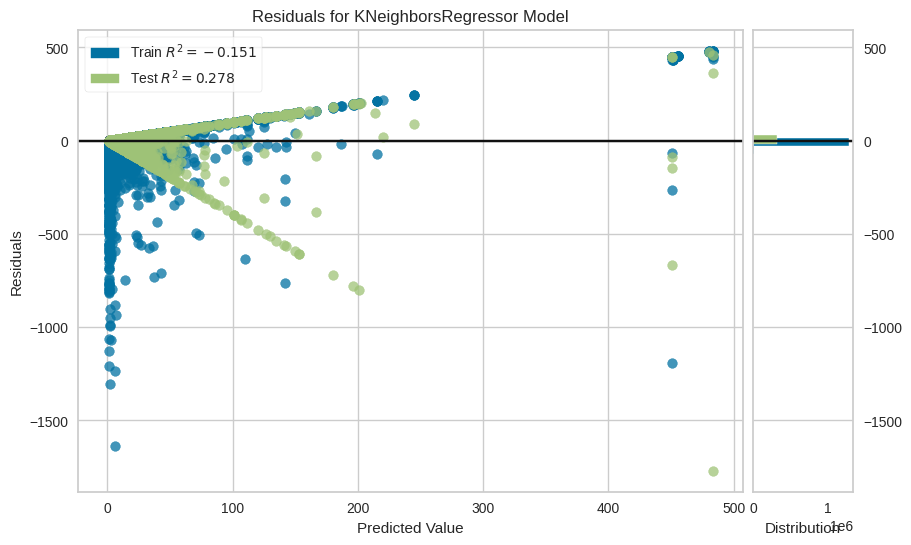

In [147]:
from yellowbrick.regressor import ResidualsPlot
fig, ax = plt.subplots(figsize=(10, 6))
rpv = ResidualsPlot(model_knn)
rpv.fit(x_treino2, y_treino2)
rpv.score(x_teste2, y_teste2)
rpv.poof();

In [148]:
r_2_prev1_knn= np.mean(resultado_KNN_r2_prev1)
MAE_prev1_knn = np.mean(resultado_KNN_MAE_prev1)
MSE_prev1_knn = np.mean(resultado_KNN_MSE_prev1)
MAPE_prev1_knn = np.mean(resultado_KNN_MAPE_prev1)

In [149]:
t = np.array([MAE_prev1_knn ,MSE_prev1_knn, MAPE_prev1_knn, r_2_prev1_knn])
t.shape = (1,4)

dtf_prev1_knn = pd.DataFrame(t, index=['Valores'], columns=['MAE','RMSE', 'MAPE','R^2'])
round(dtf_prev1_knn ,3)

,MAE,RMSE,MAPE,R^2
Valores,-1.721,-79.623,-0.845,-0.072


## Conclusão

In [150]:
print("Resultados do modelo XGBoost:")
round(dtf_prev1_xg ,3)

Resultados do modelo XGBoost:


,MAE,RMSE,MAPE,R^2
Valores,-1.615,-66.743,-0.829,0.109


In [151]:
print("Resultados do modelo CatBoost:")
round(dtf_prev1_cat ,3)

Resultados do modelo CatBoost:


,MAE,RMSE,MAPE,R^2
Valores,-1.693,-70.401,-0.88,0.059


In [152]:
print("Resultados do modelo Lightgbm:")
round(dtf_prev1_lgb ,3)

Resultados do modelo Lightgbm:


,MAE,RMSE,MAPE,R^2
Valores,-1.651,-66.973,-0.86,0.106


In [153]:
print("Resultados do modelo Regressão Linear:")
round(dtf_prev1_lr ,3)

Resultados do modelo Regressão Linear:


,MAE,RMSE,MAPE,R^2
Valores,-1.762,-74.869,-0.941,0.0


In [154]:
print(f"Resultados do modelo KNN:")
round(dtf_prev1_knn ,3)

Resultados do modelo KNN:


,MAE,RMSE,MAPE,R^2
Valores,-1.721,-79.623,-0.845,-0.072


Considerando todas as métricas, o modelo XGBoost se destacou como o melhor, apresentando os menores valores de MAE, RMSE e MAPE, além de um R^2 positivo e superior aos demais. Portanto, a escolha final recai sobre o modelo XGBoost, devido ao seu desempenho superior nas das métricas avaliadas.

## Salvando Modelo

In [2]:
import pickle

In [156]:
pickle.dump(model_xgb, open('model_xgb.pkl', 'wb'))

In [157]:
pickle.dump(model_xgb, open('model_xgb.sav', 'wb'))

In [3]:
modelo = pickle.load(open("model_xgb.sav", "rb"))

In [6]:
resultado = modelo.predict([[1,2,3]])[0]

In [8]:
resultado

3.4250197